In [ ]:
#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from os import listdir
import os
from os.path import isfile, join

import csv
import json

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

DATADIR = 'stock_files'
GRAPHDIR = 'stock_graphs'
SPLITSDIR = 'split_files'

plt.style.use('seaborn-whitegrid')

In [ ]:
#Define Functions

In [ ]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

def enrich_stock_with_smas(stock_pd):
    stock_pd["SMA2"] = stock_pd['Close'].rolling(window=2).mean()
    stock_pd["SMA5"] = stock_pd['Close'].rolling(window=5).mean()
    stock_pd["SMA10"] = stock_pd['Close'].rolling(window=10).mean()
    stock_pd["SMA25"] = stock_pd['Close'].rolling(window=25).mean()
    stock_pd["SMA50"] = stock_pd['Close'].rolling(window=50).mean()
    stock_pd["SMA90"] = stock_pd['Close'].rolling(window=90).mean()
    stock_pd["SMA120"] = stock_pd['Close'].rolling(window=120).mean()
    stock_pd["SMA180"] = stock_pd['Close'].rolling(window=180).mean()
    e_stock_pd = stock_pd
    return e_stock_pd

def enrich_stock_with_bbs(stock_pd):
    #Bollinger Bands
    stock_pd['EWMA'] = stock_pd['Close'].ewm(halflife=0.5, min_periods=20).mean()
    stock_pd['middle_band'] = stock_pd['Close'].rolling(window=20).mean()
    stock_pd['upper_band'] = stock_pd['Close'].rolling(window=20).mean() + stock_pd['Close'].rolling(window=20).std()*2
    stock_pd['lower_band'] = stock_pd['Close'].rolling(window=20).mean() - stock_pd['Close'].rolling(window=20).std()*2
    e_stock_pd = stock_pd
    return e_stock_pd

def get_latest_date(stock_pd):
    dt_latest = stock_pd.iloc[-1:].index[0]
    #dt_latest = stock_pd.iloc[-1:stock_pd.columns.get_loc("Date")]
    return dt_latest

def get_previous_date(dt_latest,nDays):
    dt_previous = dt_latest - timedelta(days=nDays)
    return dt_previous

#usage: save_graph_to_date_dir('TSLA', 'SMA', 90, datetime('2020-04-02'), datetime('2020-07-01') )
def save_graph_to_date_dir(stock_ticker, graph_type, nDays, dt_previous, dt_latest):
    stock_graph_name = stock_ticker+"_"+graph_type+"_"+str(nDays)+"_"+dt_previous.strftime("%Y-%m-%d")+"_"+dt_latest.strftime("%Y-%m-%d")
    dt_str_latest_date = dt_latest.strftime("%Y-%m-%d")
    path_ts = os.path.join(GRAPHDIR,dt_str_latest_date)
    try:
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)
        plt.savefig(path_ts+r'/'+stock_graph_name+r'.png')
        print("Saved Plot as: ["+path_ts+r'/'+stock_graph_name+".png]")
    except:
        print("Error! Could not save Plot as: ["+path_ts+r'/'+stock_graph_name+".png]")

def print_sma_chart_days(stock_ticker, stock_pd, nDays):
    dt_latest = get_latest_date(stock_pd)
    if isinstance(dt_latest, str):
        dt_latest = datetime.strptime(dt_latest,"%Y-%m-%d")
    dt_previous = get_previous_date(dt_latest,nDays)
    plt.figure(figsize=(12,10))
    plt.plot(stock_pd['SMA2'], 'r--', label="SMA2")
    plt.plot(stock_pd['SMA5'], 'y--', label="SMA5")
    plt.plot(stock_pd['SMA10'], 'g--', label="SMA10")
    plt.plot(stock_pd['SMA50'], 'c--', label="SMA50")
    plt.plot(stock_pd['SMA90'], 'm--', label="SMA90")
    plt.plot(stock_pd['SMA180'], 'b--', label="SMA180")
    plt.plot(stock_pd['Close'], label="Close")
    plt.title("["+stock_ticker+"] "+"Stock Price with SMAs from ["+dt_previous.strftime("%Y-%m-%d")+" to "+dt_latest.strftime("%Y-%m-%d")+"] | ["+str(nDays)+"] Days")
    plt.xlabel("Date")
    plt.ylabel("Price [$]")
    plt.ylim(bottom=0)
    plt.xlim([dt_previous, dt_latest])
    plt.legend()
    save_graph_to_date_dir(stock_ticker, 'SMA', nDays, dt_previous, dt_latest)
    plt.show()
    
    
def print_split_chart(stock_ticker, stock_pd, nDaysTotal, nDaysSplit):
    dt_latest = stock_pd.iloc[-1:].index[0]
    if isinstance(dt_latest, str):
        dt_latest = datetime.strptime(dt_latest,"%Y-%m-%d")
    dt_previous = dt_latest - timedelta(days=nDaysTotal)
    plt.figure(figsize=(14,4))
    #plt.plot(stock_pd['SMA2'], 'r--', label="SMA2")
    #plt.plot(stock_pd['SMA5'], 'y--', label="SMA5")
    #plt.plot(stock_pd['SMA10'], 'g--', label="SMA10")
    #plt.plot(stock_pd['SMA50'], 'c--', label="SMA50")
    #plt.plot(stock_pd['SMA90'], 'm--', label="SMA90")
    #plt.plot(stock_pd['SMA180'], 'b--', label="SMA180")
    #plt.figure(figsize=(14,4))
    plt.plot(stock_pd["Train"], 'b--', label="Train")
    plt.plot(stock_pd["Test"],'m--', label="Test")
    plt.legend(["Training Set", "Test Set"])
    #plt.plot(stock_pd['Close'], label="Close")
    plt.title("["+stock_ticker+"] "+"Stock Price with Splits ["+dt_previous.strftime("%Y-%m-%d")+" to "+dt_latest.strftime("%Y-%m-%d")+"] | ["+str(nDaysSplit)+"/"+str(nDaysTotal)+"] Days")
    plt.xlabel("Date")
    plt.ylabel("Price [$]")
    plt.ylim(bottom=0)
    plt.xlim([dt_previous, dt_latest])
    plt.legend()
    save_graph_to_date_dir(stock_ticker, 'SPLIT_'+str(nDaysTotal), nDaysSplit, dt_previous, dt_latest)
    plt.show()
    

def last_stock_date(stock_pd):
    return stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    
def first_stock_date(stock_pd):
    return stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")

def save_dataframe_as_csv(stock_pd,stock_ticker):
    dt_str_first_date = stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")
    dt_str_latest_date = stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    stock_file_name = stock_ticker+"_"+dt_str_first_date+"_"+dt_str_latest_date+".csv"
    try:
        path_ts = os.path.join(DATADIR,dt_str_latest_date)
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)
        stock_pd.to_csv(path_ts+r'/'+stock_file_name)
        print("Saved DataFrame as: ["+path_ts+r'/'+stock_file_name+"]")
    except:
        print("Error! Could not save Dataframe as: ["+path_ts+r'/'+stock_file_name+"]")

def convert_df_to_pd(stock_df):
    stock_pd = pd.DataFrame(stock_df)
    return stock_pd

def online_process_stock_once(stock_ticker,nDays):
    stock_df = yf.download(stock_ticker)
    stock_pd = convert_df_to_pd(stock_df)
    stock_pd = enrich_stock_with_smas(stock_pd)
    stock_pd = enrich_stock_with_bbs(stock_pd)
    save_dataframe_as_csv(stock_pd,stock_ticker)
    #print(stock_ticker)
    print_sma_chart_days(stock_ticker,stock_pd,nDays)

def get_list_of_files_in_dir(dir_name):
    list_of_files_only = [f for f in listdir(dir_name) if isfile(join(dir_name, f))]
    return list_of_files_only

def read_offline_csv_to_dataframe(dir_name,file_name):
    #path_ts = os.path.join(dir_name,dir_date)
    read_stock_pd = pd.read_csv(dir_name+r'/'+file_name, index_col='Date', parse_dates=['Date'])
    #read_stock_pd = pd.read_csv(path_ts+r'/'+file_name)
    #read_stock_pd['Date'] = pd.to_datetime(read_stock_pd['Date'])
    #read_stock_pd.set_index('Date', inplace=True)
    return read_stock_pd

def get_stock_ticker_name_from_file_name(file_name):
    m = re.search('(^[a-zA-Z]+?)_', file_name)
    if m:
        found = m.group(1)
    return found

def get_stock_dataframe_from_local(dir_name,stock_ticker):
    stock_pd = pd.DataFrame()
    #path_ts = os.path.join(dir_name,dir_date)
    list_of_files = get_list_of_files_in_dir(dir_name)
    for file_name in list_of_files:
        current_stock_title = get_stock_ticker_name_from_file_name(file_name)
        if stock_ticker == current_stock_title:
            stock_pd = read_offline_csv_to_dataframe(dir_name,file_name)
            break
    return stock_pd

def offline_process_stock_once(dir_name,stock_ticker,nDays):
    stock_pd = get_stock_dataframe_from_local(dir_name,stock_ticker)
    print(stock_ticker)
    print_sma_chart_days(stock_ticker,stock_pd,nDays)
    
### Train, Test Split
    
#useage: stock_pd["Train"], stock_pd["Test"] = split(stock_pd, "2020-04-01", "Close")
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

def split_based_on_days(stock_pd,nDaysToSplit,split_column_head_str):    
    dt_latest = get_latest_date(stock_pd)
    dt_previous = get_previous_date(dt_latest,nDaysToSplit)
    dt_str_previous = dt_previous.strftime("%Y-%m-%d")
    border = dt_str_previous
    col = split_column_head_str
    dataframe = stock_pd
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

def edit_stock_split_last_days(stock_pd,nDays,split_column_head_str):
    dt_latest = get_latest_date(stock_pd)
    dt_previous = get_previous_date(dt_latest,nDays)
    dt_str_previous = dt_previous.strftime("%Y-%m-%d")
    stock_pd["Train"], stock_pd["Test"] = split(stock_pd, dt_str_previous, split_column_head_str)
    return stock_pd

def save_splits_to_csv(ticker, path_ts,stock_pd_split):
    try:
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)
            print("Created new Dir: ["+path_ts+"]")
    except:
        print("Error! Issue with creating/accessing: ["+path_ts+"]")
    container_name = ticker+'_container.csv' 
    train_name = ticker+'_train.csv'  
    test_name = ticker+'_test.csv'  
    with open(path_ts+r'/'+container_name, 'w') as outfile:
        writer = csv.writer(outfile)
        for key, val in stock_pd_split.items():
            writer.writerow([key, val])
    with open(path_ts+r'/'+train_name, 'w') as outfile:
        writer = csv.writer(outfile)
        for key, val in stock_pd_split['Train'].items():
            writer.writerow([key, val])
    with open(path_ts+r'/'+test_name, 'w') as outfile:
        writer = csv.writer(outfile)
        for key, val in stock_pd_split['Test'].items():
            writer.writerow([key, val])
    print("Saved files in: [{}/] {} {} {}".format(path_ts,container_name,train_name,test_name))

def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag 5", mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5])))

    plt.figure(figsize=(14,4))
    plt.title("Prediction without Lag")
    plt.plot(df_true)
    plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5]))
    plt.figure(figsize=(14,4))
    plt.title("Prediction with Lag")
    plt.plot(df_true)
    plt.plot(df_pred_lag)

In [ ]:
### RUN ONLINE UNIT TEST

In [ ]:
tickers_to_iterate = ['TSLA']
for ticker_name in tickers_to_iterate:
    online_process_stock_once(ticker_name,180)

In [ ]:
### RUN OFFLINE UNIT TEST

In [ ]:
tickers_to_iterate = ['TSLA']
date_folder = '2020-07-02'
for ticker_name in tickers_to_iterate:
    path_ts = os.path.join(DATADIR,date_folder)
    offline_process_stock_once(path_ts,ticker_name,180)

In [ ]:
### ML KERAS EXPERIMENTATION (LOCAL)

In [ ]:
tickers_to_iterate = ['TSLA']
date_folder = '2020-07-02'
for ticker_name in tickers_to_iterate:
    path_ts = os.path.join(DATADIR,date_folder)
    stock_pd = get_stock_dataframe_from_local(path_ts,ticker_name)
    #stock_pd["Train"], stock_pd["Test"] = split(stock_pd, "2020-04-01", "Close")
    nDaysToSplit = 45
    nDaysTotal = 180
    stock_pd = edit_stock_split_last_days(stock_pd,nDaysToSplit,"Close")
    print_split_chart(ticker_name,stock_pd,nDaysTotal,nDaysToSplit)

In [ ]:
### ML KERAS PRODUCTION EXPERIMENTATION (LOCAL)

In [ ]:
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
date_folder = '2020-07-02'
path_ts = os.path.join(DATADIR,date_folder)
nDaysToSplit = 45
nDaysTotal = 180

for ticker_name in tickers_to_iterate:
    stock_pd = get_stock_dataframe_from_local(path_ts,ticker_name)
    #stock_pd = edit_stock_split_last_days(stock_pd,nDaysToSplit,"Close")
    #print_split_chart(ticker_name,stock_pd,nDaysTotal,nDaysToSplit)

In [ ]:
### PRODUCTION ONLINE EXPERIMENTATION

Saved DataFrame as: [stock_files/2020-07-02/INTC_1980-03-17_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/INTC_SMA_180_2020-01-04_2020-07-02.png]


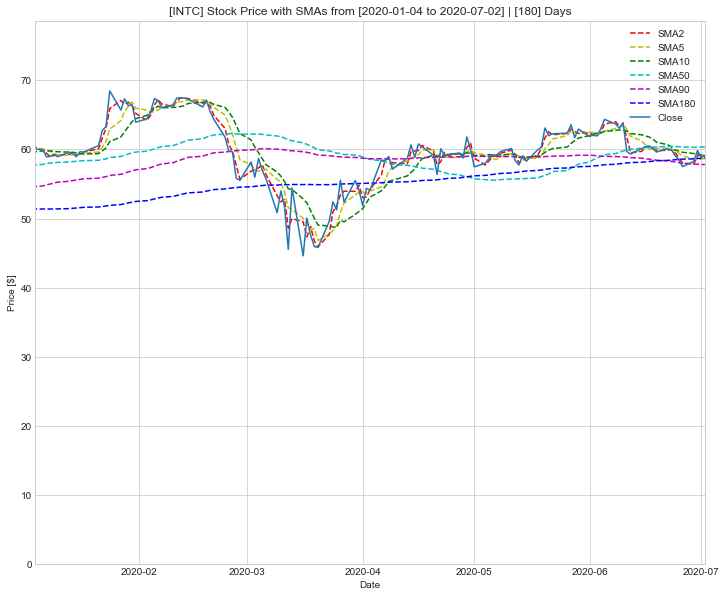

[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [stock_files/2020-07-02/QCOM_1991-12-13_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/QCOM_SMA_180_2020-01-04_2020-07-02.png]


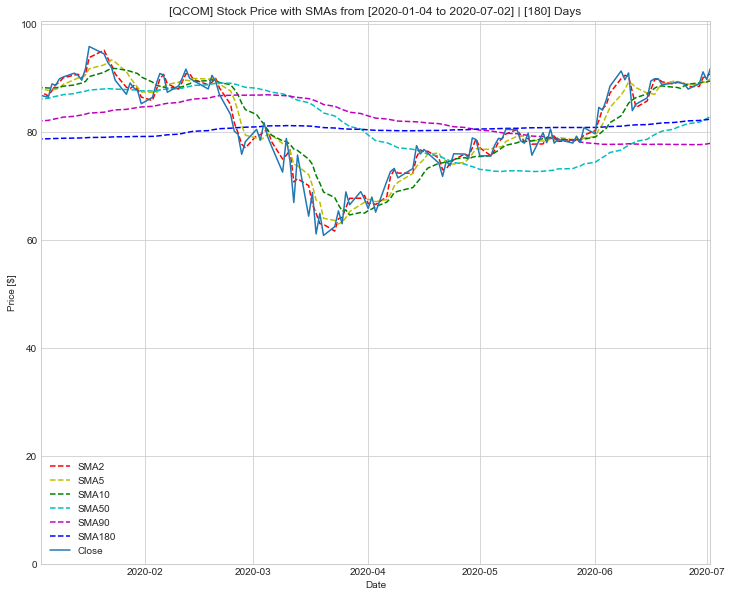

[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [stock_files/2020-07-02/MU_1984-06-01_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/MU_SMA_180_2020-01-04_2020-07-02.png]


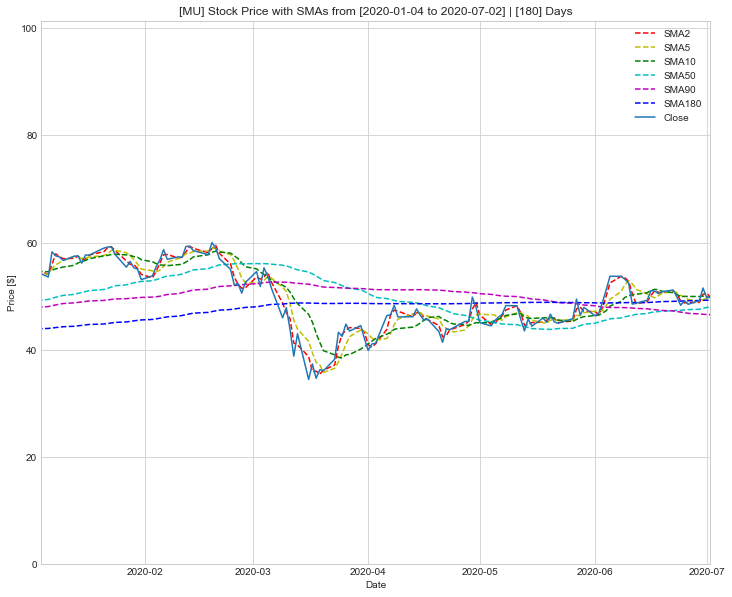

In [34]:
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
for ticker_name in tickers_to_iterate:
    online_process_stock_once(ticker_name,180)

In [ ]:
### PRODUCTION OFFLINE EXPERIMENTATION

In [35]:
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
for ticker_name in tickers_to_iterate:
    offline_process_stock_once(DATADIR,ticker_name)

TypeError: offline_process_stock_once() missing 1 required positional argument: 'nDays'

In [ ]:
### 2020-07-05 PRODUCTION OFFLINE KERAS EXPERIMENTATION

In [ ]:
tickers_to_iterate = ['TSLA','NVDA', 'GOOG']
date_folder = '2020-07-02'
nDaysToSplit = 500
nDaysTotal = 1500
path_ts = os.path.join(DATADIR,date_folder)

today_date_folder = str(datetime.now().strftime("%Y-%m-%d"))
split_path_ts = os.path.join(SPLITSDIR,today_date_folder)

stock_pds = {}
stock_pds_split = {}
transform_train = {}
transform_test = {}
scaler = {}


for i, ticker_name in enumerate(tickers_to_iterate):
    #possibly redundant with below
    stock_pd = get_stock_dataframe_from_local(path_ts,ticker_name)
    stock_pd = edit_stock_split_last_days(stock_pd,nDaysToSplit,"Close")
    stock_pds[i] = stock_pd
    
    #possibly redundant with above
    stock_pds_split[i] = {}
    stock_pds_split[i]["Train"], stock_pds_split[i]["Test"] = split_based_on_days(stock_pds[i], nDaysToSplit, "Close")
    
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(stock_pds_split[i]["Train"])
    a1 = np.array(stock_pds_split[i]["Test"])
    #remove NaN and reshape
    #a0 = a0[np.logical_not(np.isnan(a0))]
    #a1 = a1[np.logical_not(np.isnan(a1))]
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    del a0
    del a1
    
    #save_splits_to_csv(ticker_name,split_path_ts,stock_pds_split[i])

print("Train:")
for i in transform_train.keys():
    print(i, tickers_to_iterate[i], transform_train[i].shape)
print("\nTest:")    
for i in transform_test.keys():
    print(i, tickers_to_iterate[i], transform_test[i].shape)

In [ ]:
#print(stock_pds_split[0])

tickers_to_iterate = ['TSLA']
topday_date_folder = str(datetime.now().strftime("%Y-%m-%d"))
path_ts = os.path.join(SPLITSDIR,date_folder)
    
save_splits_to_csv(tickers_to_iterate[0],path_ts,stock_pds_split[0])

In [ ]:
trainset = {}
testset = {}
#how many input features in your model
nn_feature_size = 60
#make this smaller than the smallest max training values
training_max_length = 1800
#make this smaller than the smallest max test values
test_max_length = 300


for j, ticker in enumerate(tickers_to_iterate):
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(nn_feature_size,training_max_length):
        X_train.append(transform_train[j][i-nn_feature_size:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(nn_feature_size, test_max_length):
        X_test.append(transform_test[j][i-nn_feature_size:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [ ]:
### OUTPUT THE CURRENT SPLITS
arr_buff = []
for i, ticker in enumerate(tickers_to_iterate):
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=tickers_to_iterate)

In [ ]:
### OFFLINE MODEL TRAINING EXPERIMENTATION

In [ ]:
%%time

# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i, ticker in enumerate(tickers_to_iterate):
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)


In [ ]:
pred_result = {}
for i, ticker in enumerate(tickers_to_iterate):
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} Predictions - {} with MSE {:10.4f}".format(ticker,i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.show()
    

    

In [ ]:
time_index = stock_pds_split[0]["Test"][nn_feature_size:].index
print(time_index)

lagging(pred_result[0], -5, time_index)


In [ ]:
### LAGGING TEST

In [ ]:
### GATED RECURRENT UNITS

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
for i, ticker in enumerate(tickers_to_iterate):
    print("Fitting to", i)
    regressorGRU.fit(trainset[i]["X"], trainset[i]["y"],epochs=50,batch_size=150)


In [ ]:
for i, ticker in enumerate(tickers_to_iterate):
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressorGRU.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    
    plt.figure(figsize=(14,6))
    plt.title("{} Predictions (GRU) - {} with MSE {:10.4f}".format(ticker,i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

In [ ]:
### Testing

In [ ]:
path_ts = os.path.join(DATADIR,'2020-07-02')
list_of_files = get_list_of_files_in_dir(path_ts)
print(list_of_files)

In [ ]:
colors = ["red", "green", "blue", "purple"]
ratios = [0.2, 0.3, 0.1, 0.4]
for i, color in enumerate(colors):
    ratio = ratios[i]
    print("{}% {}".format(ratio * 100, color))
